In [68]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV,SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import KNNImputer
sns.set_theme()

# EDA

In [69]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [70]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [71]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [73]:
df.duplicated().values.any()

np.False_

In [74]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [75]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [76]:
def obtener_semana_mes(fecha):
    return min(int(np.ceil(fecha.day / 7)), 4)

In [77]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

In [78]:
df_copy.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [79]:
# Drop de unica fila Nan
df_copy.dropna(inplace=True)

Se aprecian valores atípicos muy alejados de la media de los datos y valores negativos imposibles.

<Axes: ylabel='fare_amount'>

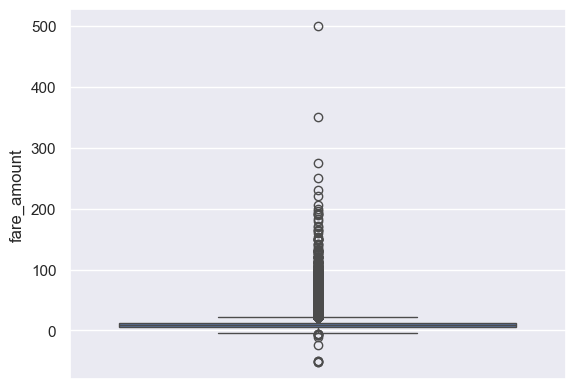

In [80]:
sns.boxplot(df_copy["fare_amount"])

In [81]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]

In [82]:
# Filas con precios atípicos
df_copy[(df_copy["fare_amount"] > 200) | (df_copy["fare_amount"] < 0)]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.00,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3
23682,38390943,2014-11-02 22:40:20.0000004,206.38,2014-11-02 22:40:20 UTC,-73.782161,40.644601,-74.449079,40.836457,1
29261,5471406,2013-09-27 12:36:11.0000002,220.00,2013-09-27 12:36:11 UTC,-73.801147,40.671653,-73.790402,40.646742,1
63395,30260042,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,51325304,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
71715,38680012,2013-05-11 00:31:00.00000084,250.00,2013-05-11 00:31:00 UTC,0.000000,0.000000,0.000000,0.000000,1
79903,50284253,2015-05-01 14:43:02.0000004,-3.50,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1
89322,26673143,2010-03-09 08:26:10.0000006,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5
92063,10267585,2010-03-12 08:49:10.0000002,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3
98875,51135168,2015-03-20 21:31:14.0000007,-52.00,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5


filtramos estos valores atipicos de nuestra columna target

In [83]:
df_copy = df_copy[(df_copy["fare_amount"] < 200) & (df_copy["fare_amount"] > 0)] 

In [84]:
df_copy["fare_amount"].describe()

count    199968.000000
mean         11.351885
std           9.733257
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         196.000000
Name: fare_amount, dtype: float64

Se observa que aproximadamente el 2% de las filas tienen mas de un valor faltanrte en las coordendas, lo que dificulta el cálculo de la distancia.

In [85]:
# Mas de 3 columnas de coordenadas con 0 lo filtramos
coords = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
conteo_ceros = (df_copy[coords] == 0.0).sum(axis=1)
pd.Series(conteo_ceros).value_counts()

0    196006
4      3583
2       359
1        20
Name: count, dtype: int64

Eliminación de filas con coordenadas faltantes

In [86]:
df_copy = df_copy[conteo_ceros == 0]

# Ingenieria de caracteristicas

In [87]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [88]:
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [89]:
# Extraer la hora del pickup_datetime
df_copy['hora'] = df_copy['pickup_datetime'].dt.hour

# Aplicar transformación trigonométrica para la hora (ciclo de 24 horas)
n = 24
df_copy["hora_sin"] = np.sin(2 * np.pi * df_copy["hora"] / n)
df_copy["hora_cos"] = np.cos(2 * np.pi * df_copy["hora"] / n)


In [90]:
df_copy.drop(columns=["dia_semana","hora"], inplace=True)

In [91]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [92]:
# Eliminación de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [93]:
df_copy["semana_mes"] = df_copy["pickup_datetime"].apply(obtener_semana_mes)

In [94]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,-0.965926,0.258819,1.683323,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,-0.866025,0.500000,2.457590,3
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,-0.707107,0.707107,5.036377,4
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,4
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,-0.965926,-0.258819,4.475450,4


In [95]:
df_copy["semana_mes"].value_counts()

semana_mes
4    59395
2    46439
3    46297
1    43875
Name: count, dtype: int64

In [96]:
coords = ["key","pickup_datetime" ,"pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
df_copy.drop(columns=coords, inplace=True)

In [97]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196006 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      196006 non-null  float64
 1   passenger_count  196006 non-null  Int64  
 2   dia_sin          196006 non-null  float64
 3   dia_cos          196006 non-null  float64
 4   hora_sin         196006 non-null  float64
 5   hora_cos         196006 non-null  float64
 6   distance_km      196006 non-null  float64
 7   semana_mes       196006 non-null  int64  
dtypes: Int64(1), float64(6), int64(1)
memory usage: 13.6 MB


In [98]:
# Creación de dummies en columna franja horaria
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['semana_mes', 'passenger_count']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['semana_mes', 'passenger_count']))

df_encoded = pd.concat([df_copy.drop(columns=['semana_mes', 'passenger_count']), encoded_df], axis=1)

df_encoded.head()


,fare_amount,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
0,7.5,0.433884,-0.900969,-0.965926,0.258819,1.683323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.7,-0.433884,-0.900969,-0.866025,0.500000,2.457590,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12.9,0.000000,1.000000,-0.707107,0.707107,5.036377,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,16.0,0.433884,-0.900969,-0.965926,-0.258819,4.475450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [99]:
cols_dummies = [c for c in df_encoded.columns if c.startswith("franja_horaria_") or c.startswith("semana_mes_") or c.startswith("passenger_count_")]
df_encoded[cols_dummies] = df_encoded[cols_dummies].astype('Int32')

In [100]:
df_encoded.columns

Index(['fare_amount', 'dia_sin', 'dia_cos', 'hora_sin', 'hora_cos',
       'distance_km', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4',
       'passenger_count_1.0', 'passenger_count_2.0', 'passenger_count_3.0',
       'passenger_count_4.0', 'passenger_count_5.0', 'passenger_count_6.0'],
      dtype='object')

In [101]:
not_dummy_cols = ["fare_amount","dia_sin","dia_cos","hora_sin","hora_cos","distance_km"]
df_encoded[not_dummy_cols] = df_encoded[not_dummy_cols].astype("float32")

In [102]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199917 entries, 0 to 195975
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fare_amount          196006 non-null  float32
 1   dia_sin              196006 non-null  float32
 2   dia_cos              196006 non-null  float32
 3   hora_sin             196006 non-null  float32
 4   hora_cos             196006 non-null  float32
 5   distance_km          196006 non-null  float32
 6   semana_mes_2         196006 non-null  Int32  
 7   semana_mes_3         196006 non-null  Int32  
 8   semana_mes_4         196006 non-null  Int32  
 9   passenger_count_1.0  196006 non-null  Int32  
 10  passenger_count_2.0  196006 non-null  Int32  
 11  passenger_count_3.0  196006 non-null  Int32  
 12  passenger_count_4.0  196006 non-null  Int32  
 13  passenger_count_5.0  196006 non-null  Int32  
 14  passenger_count_6.0  196006 non-null  Int32  
dtypes: Int32(9), float32(6

In [103]:
df_encoded.isna().sum()

fare_amount            3911
dia_sin                3911
dia_cos                3911
hora_sin               3911
hora_cos               3911
distance_km            3911
semana_mes_2           3911
semana_mes_3           3911
semana_mes_4           3911
passenger_count_1.0    3911
passenger_count_2.0    3911
passenger_count_3.0    3911
passenger_count_4.0    3911
passenger_count_5.0    3911
passenger_count_6.0    3911
dtype: int64

In [104]:
# Eliminación filas con nulos
df_encoded.dropna(inplace=True)

# Modelo de regresion

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)

In [106]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153676 entries, 61947 to 124473
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dia_sin              153676 non-null  float32
 1   dia_cos              153676 non-null  float32
 2   hora_sin             153676 non-null  float32
 3   hora_cos             153676 non-null  float32
 4   distance_km          153676 non-null  float32
 5   semana_mes_2         153676 non-null  Int32  
 6   semana_mes_3         153676 non-null  Int32  
 7   semana_mes_4         153676 non-null  Int32  
 8   passenger_count_1.0  153676 non-null  Int32  
 9   passenger_count_2.0  153676 non-null  Int32  
 10  passenger_count_3.0  153676 non-null  Int32  
 11  passenger_count_4.0  153676 non-null  Int32  
 12  passenger_count_5.0  153676 non-null  Int32  
 13  passenger_count_6.0  153676 non-null  Int32  
dtypes: Int32(9), float32(5)
memory usage: 10.7 MB


In [107]:
X_train[X_train["distance_km"] == 0]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
104531,-0.433884,-0.900969,-1.000000,-1.836970e-16,0.0,0,1,0,1,0,0,0,0,0
50671,-0.781832,0.623490,0.258819,-9.659258e-01,0.0,0,1,0,0,1,0,0,0,0
192650,-0.974928,-0.222521,0.707107,7.071068e-01,0.0,0,1,0,1,0,0,0,0,0
44670,-0.433884,-0.900969,0.258819,9.659258e-01,0.0,0,1,0,1,0,0,0,0,0
97030,0.781832,0.623490,-0.707107,-7.071068e-01,0.0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9518,0.433884,-0.900969,-0.707107,7.071068e-01,0.0,0,1,0,1,0,0,0,0,0
169671,0.781832,0.623490,-1.000000,-1.836970e-16,0.0,0,0,1,1,0,0,0,0,0
85309,0.781832,0.623490,-1.000000,-1.836970e-16,0.0,0,0,0,1,0,0,0,0,0
89685,0.781832,0.623490,-0.866025,-5.000000e-01,0.0,0,0,0,1,0,0,0,0,0


In [108]:
X_train[X_train["distance_km"] < 0.1]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
61947,-0.974928,-0.222521,1.224647e-16,-1.000000e+00,0.020103,0,0,1,1,0,0,0,0,0
104531,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,0.000000,0,1,0,1,0,0,0,0,0
50671,-0.781832,0.623490,2.588190e-01,-9.659258e-01,0.000000,0,1,0,0,1,0,0,0,0
77340,0.974928,-0.222521,7.071068e-01,-7.071068e-01,0.022376,0,0,0,0,1,0,0,0,0
192650,-0.974928,-0.222521,7.071068e-01,7.071068e-01,0.000000,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135999,-0.433884,-0.900969,-7.071068e-01,7.071068e-01,0.000000,1,0,0,0,0,0,0,1,0
98564,0.000000,1.000000,1.000000e+00,6.123234e-17,0.001560,0,1,0,1,0,0,0,0,0
91894,0.974928,-0.222521,2.588190e-01,-9.659258e-01,0.010957,0,0,1,1,0,0,0,0,0
65319,0.433884,-0.900969,7.071068e-01,7.071068e-01,0.022474,1,0,0,1,0,0,0,0,0


In [109]:
# Muy pocos viajes en los nuevos dataset con distancias mayores a 60
X_train[X_train["distance_km"] > 90].shape[0], X_test[X_test["distance_km"] > 90].shape[0]

(89, 16)

In [110]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 90) | (X_train["distance_km"] < 0.1), "distance_km"] = np.nan

In [111]:
X_test.loc[(X_test["distance_km"] > 90) | (X_test["distance_km"] < 0.1), "distance_km"] = np.nan

<Axes: xlabel='distance_km', ylabel='Count'>

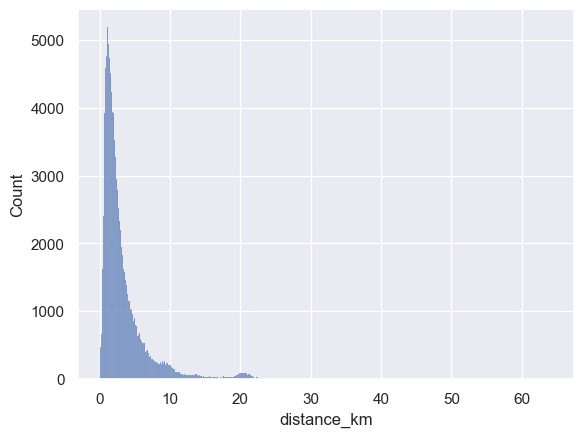

In [112]:
sns.histplot(X_train["distance_km"])

In [113]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,153676.000000,153676.000000,153676.000000,153676.000000,151080.000000,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0
mean,-0.001362,-0.044921,-0.194445,-0.069066,3.362822,0.236615,0.236348,0.302825,0.691748,0.147141,0.044509,0.0212,0.070271,0.021617
std,0.711047,0.701712,0.668791,0.714245,3.596675,0.425005,0.42484,0.459482,0.461773,0.354247,0.206224,0.144053,0.255604,0.14543
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.293250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.189097,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,3.943789,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,64.192810,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [114]:
# Todas las columnas numéricas
cols_to_impute = X_train.columns  

# Instanciar imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Fit en train, transform en train y test
X_train_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train[cols_to_impute]),
    columns=cols_to_impute,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    knn_imputer.transform(X_test[cols_to_impute]),
    columns=cols_to_impute,
    index=X_test.index
)

# Sobrescribís solo la columna distance_km si no querés tocar las demás
X_train["distance_km"] = X_train_imputed["distance_km"]
X_test["distance_km"] = X_test_imputed["distance_km"]

KeyboardInterrupt: 

In [ ]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,153676.000000,153676.000000,153676.000000,153676.000000,153676.000000,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0,153676.0
mean,-0.001362,-0.044921,-0.194445,-0.069066,3.363943,0.236615,0.236348,0.302825,0.691748,0.147141,0.044509,0.0212,0.070271,0.021617
std,0.711047,0.701712,0.668791,0.714245,3.573110,0.425005,0.42484,0.459482,0.461773,0.354247,0.206224,0.144053,0.255604,0.14543
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.305477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.208131,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,3.952395,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,64.192810,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: xlabel='distance_km', ylabel='Count'>

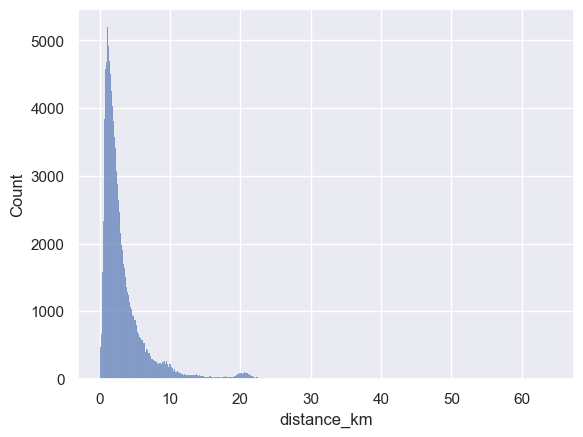

In [ ]:
sns.histplot(X_train["distance_km"])

<Axes: xlabel='distance_km', ylabel='Count'>

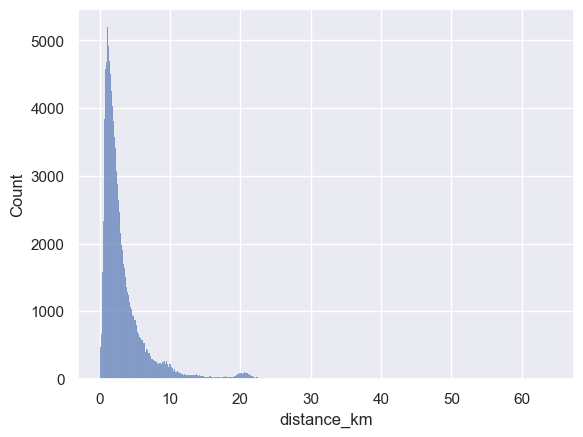

In [ ]:
sns.histplot(X_train["distance_km"])

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_test.describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.0,38419.0,38419.0,38419.0,38419.0,38419.0,38419.0,38419.0,38419.0
mean,-0.001362,-0.040324,-0.196954,-0.069944,3.406506,0.237773,0.235248,0.303808,0.691559,0.148442,0.044743,0.021864,0.069289,0.020719
std,0.711715,0.701327,0.667997,0.714229,3.614183,0.425725,0.424159,0.459907,0.461856,0.355542,0.206743,0.146242,0.253948,0.142444
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.313354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.224865,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,4.016222,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,62.071495,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
pd.DataFrame(X_test_scaled,columns=X_test.columns).describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000
mean,-0.000871,0.119516,0.045289,0.133555,0.452743,0.237773,0.235248,0.303808,-0.308441,0.148442,0.044743,0.021864,0.069289,0.020719
std,0.455159,0.460050,0.489008,0.505036,1.365431,0.425725,0.424159,0.459907,0.461856,0.355542,0.206743,0.146242,0.253948,0.142444
min,-0.623490,-0.445042,-0.542582,-0.524094,-0.796285,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.500000,-0.445042,-0.444506,-0.316987,-0.338045,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.006322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.554958,0.555494,0.683013,0.683093,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.623490,0.801938,0.921520,0.890119,22.616257,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# crear un pipeline para la preprocesamiento y el modelo
pipeline = Pipeline([ 
    ('Linear', LinearRegression())  
])

# ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train_scaled, y_train)

# hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test_scaled)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 2.37
RMSE: 4.72
R²: 0.77


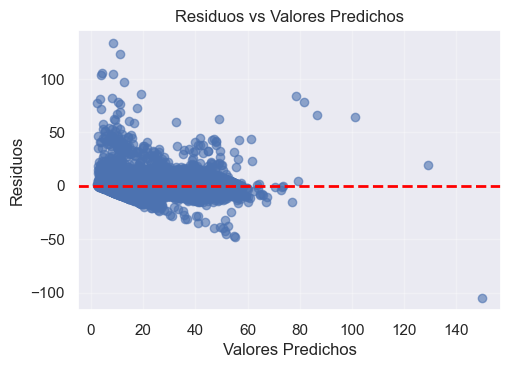

In [ ]:
residuos = y_test - y_pred

# Crear gráfico de residuos
plt.figure(figsize=(12, 8))

# Gráfico 1: Residuos vs Valores Predichos
plt.subplot(2, 2, 1)
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

<Axes: ylabel='fare_amount'>

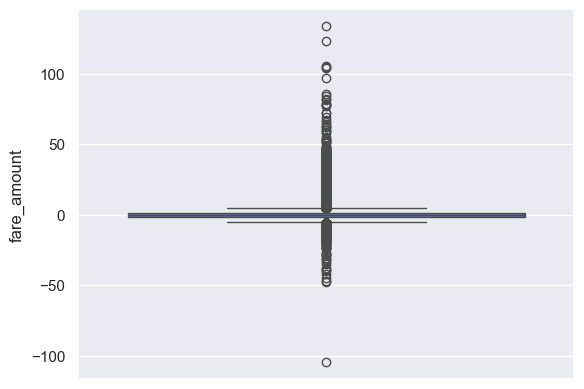

In [ ]:
sns.boxplot(residuos)

<Axes: xlabel='fare_amount', ylabel='Count'>

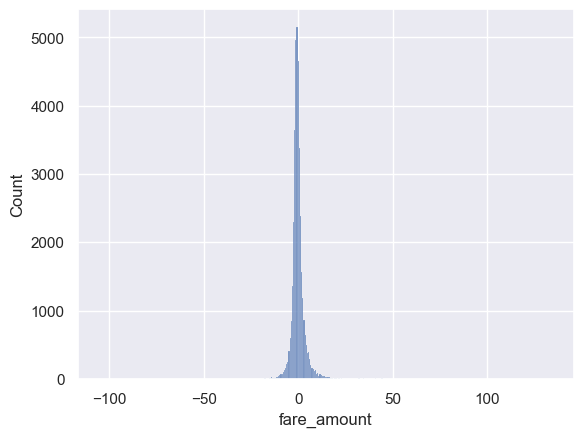

In [ ]:
sns.histplot(residuos)

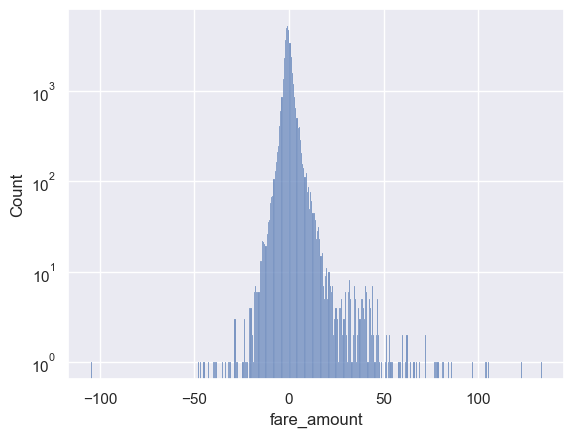

In [ ]:
sns.histplot(residuos)
plt.yscale("log")

Grafico de residuos FALTA

Visualización de coeficientes.

In [ ]:
regressor = pipeline.named_steps['Linear']

# Obtener coeficientes
coefs = regressor.coef_

# Crear DataFrame que relacione variable con su coeficiente
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': coefs
})

print(coef_df)

               Variable  Coeficiente
0               dia_sin     0.268197
1               dia_cos    -0.366379
2              hora_sin    -0.406062
3              hora_cos    -1.123131
4           distance_km     6.244498
5          semana_mes_2    -0.073447
6          semana_mes_3    -0.095116
7          semana_mes_4    -0.071920
8   passenger_count_1.0     0.361858
9   passenger_count_2.0     0.427740
10  passenger_count_3.0     0.335672
11  passenger_count_4.0     0.381625
12  passenger_count_5.0     0.384627
13  passenger_count_6.0     0.531215


# Gradiente 

In [ ]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

# def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

#   n = X_train.shape[0]
#   m = X_train.shape[1]

#   X_train = np.hstack((np.ones((n, 1)), X_train))
#   X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

#   W = np.random.randn(m + 1).reshape(-1, 1)

#   train_errors = []
#   test_errors = []

#   for i in range(epochs):
#     # Permutación aleatoria de los datos
#     permutation = np.random.permutation(n)
#     X_train = X_train[permutation]
#     y_train = y_train[permutation]

#     for j in range(n):
#         # Obtener una muestra aleatoria de un solo dato para hacer SGD
#         x_sample = X_train[j]
#         y_sample = y_train[j][0]

#         prediction = np.matmul(x_sample, W)
#         error = y_sample - prediction
#         train_mse = error ** 2
#         train_errors.append(train_mse)

#         prediction_test = np.matmul(X_test, W)
#         error_test = y_test - prediction_test
#         test_mse = np.mean(error_test ** 2)
#         test_errors.append(test_mse)

#         gradient = -2 * error * x_sample.T.reshape(-1, 1)

#         W = W - (lr * gradient)

        

#   plt.figure(figsize=(12, 6))
#   plt.plot(train_errors, label='Error de entrenamiento')
#   plt.plot(test_errors, label='Error de prueba')
#   plt.xlabel('Iteración')
#   plt.ylabel('Error cuadrático medio')
#   plt.legend()
#   plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
#   plt.show()

#   return W

# def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32):
#   n = X_train.shape[0]
#   m = X_train.shape[1]

#   X_train = np.hstack((np.ones((n, 1)), X_train))
#   X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

#   W = np.random.randn(m + 1).reshape(-1, 1)

#   train_errors = []
#   test_errors = []

#   for i in range(epochs):
      
#       # Permutación aleatoria de los datos
#       permutation = np.random.permutation(n)
#       X_train = X_train[permutation]
#       y_train = y_train[permutation]


#       for j in range(0, n, batch_size):
#           # Obtener un lote (mini-batch) de datos
#           x_batch = X_train[j:j+batch_size, :]
#           y_batch = y_train[j:j+batch_size].reshape(-1, 1)

#           prediction = np.matmul(x_batch, W)
#           error = y_batch - prediction
#           train_mse = np.mean(error ** 2)
#           train_errors.append(train_mse)

#           gradient = -2 * np.matmul(x_batch.T, error) / batch_size

#           W = W - (lr * gradient)

#           prediction_test = np.matmul(X_test, W)
#           error_test = y_test - prediction_test
#           test_mse = np.mean(error_test ** 2)
#           test_errors.append(test_mse)

#   plt.figure(figsize=(12, 6))
#   plt.plot(train_errors, label='Error de entrenamiento')
#   plt.plot(test_errors, label='Error de prueba')
#   plt.xlabel('Iteración')
#   plt.ylabel('Error cuadrático medio')
#   plt.legend()
#   plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
#   plt.show()

#   return W

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

#     n_train = X_train.shape[0]
#     n_test = X_test.shape[0]
#     m = X_train.shape[1]

#     X_train_bias = np.hstack((np.ones((n_train, 1)), X_train))
#     X_test_bias = np.hstack((np.ones((n_test, 1)), X_test))

#     W = np.random.randn(m + 1).reshape(-1, 1)

#     train_errors = []
#     test_errors = []

#     for i in range(epochs):
#         # Permutación aleatoria de los datos
#         permutation = np.random.permutation(n_train)
#         X_train_shuffled = X_train_bias[permutation]
#         y_train_shuffled = y_train[permutation]

#         for j in range(n_train):
#             # Obtener una muestra aleatoria de un solo dato para hacer SGD
#             x_sample = X_train_shuffled[j].reshape(1, -1) # Reshape for matrix multiplication
#             y_sample = y_train_shuffled[j].reshape(1, -1)

#             prediction = np.matmul(x_sample, W)
#             error = y_sample - prediction
            
#             # Cálculo del gradiente y actualización de los pesos
#             gradient = -2 * np.matmul(x_sample.T, error)
#             W = W - (lr * gradient)
        
#         # Después de cada época, calcula el error para todo el conjunto de datos
#         # de entrenamiento y prueba y lo agrega a las listas
#         prediction_train_all = np.matmul(X_train_bias, W)
#         train_mse = np.mean((y_train.reshape(-1, 1) - prediction_train_all) ** 2)
#         train_errors.append(train_mse)

#         prediction_test_all = np.matmul(X_test_bias, W)
#         test_mse = np.mean((y_test.reshape(-1, 1) - prediction_test_all) ** 2)
#         test_errors.append(test_mse)

#     plt.figure(figsize=(12, 6))
#     plt.plot(range(1, epochs + 1), train_errors, label='Error de entrenamiento')
#     plt.plot(range(1, epochs + 1), test_errors, label='Error de prueba')
#     plt.xlabel('Época')
#     plt.ylabel('Error cuadrático medio')
#     plt.legend()
#     plt.title('Error de entrenamiento y prueba vs Épocas (SGD)')
#     plt.show()

#     return W

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=31):
#     n_train = X_train.shape[0]
#     n_test = X_test.shape[0]
#     m = X_train.shape[1]

#     X_train_bias = np.hstack((np.ones((n_train, 1)), X_train))
#     X_test_bias = np.hstack((np.ones((n_test, 1)), X_test))

#     W = np.random.randn(m + 1).reshape(-1, 1)

#     train_errors = []
#     test_errors = []

#     for i in range(epochs):
#         # Permutación aleatoria de los datos
#         permutation = np.random.permutation(n_train)
#         X_train_shuffled = X_train_bias[permutation]
#         y_train_shuffled = y_train[permutation]

#         for j in range(0, n_train, batch_size):
#             # Obtener un lote (mini-batch) de datos
#             x_batch = X_train_shuffled[j:j+batch_size, :]
#             y_batch = y_train_shuffled[j:j+batch_size].reshape(-1, 1)

#             prediction = np.matmul(x_batch, W)
#             error = y_batch - prediction
            
#             # Cálculo del gradiente y actualización de los pesos
#             gradient = -2 * np.matmul(x_batch.T, error) / batch_size
#             W = W - (lr * gradient)
        
#         # Después de cada época, calcula el error para todo el conjunto de datos
#         # de entrenamiento y prueba y lo agrega a las listas
#         prediction_train_all = np.matmul(X_train_bias, W)
#         train_mse = np.mean((y_train.reshape(-1, 1) - prediction_train_all) ** 2)
#         train_errors.append(train_mse)

#         prediction_test_all = np.matmul(X_test_bias, W)
#         test_mse = np.mean((y_test.reshape(-1, 1) - prediction_test_all) ** 2)
#         test_errors.append(test_mse)

#     plt.figure(figsize=(12, 6))
#     plt.plot(range(1, epochs + 1), train_errors, label='Error de entrenamiento')
#     plt.plot(range(1, epochs + 1), test_errors, label='Error de prueba')
#     plt.xlabel('Época')
#     plt.ylabel('Error cuadrático medio')
#     plt.legend()
#     plt.title('Error de entrenamiento y prueba vs Épocas (Mini-Batch GD)')
#     plt.show()

#     return W

In [ ]:
# Escalado para correcto funcionamiento de GD
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

Época 10/100, Train MSE: 23.4674, Test MSE: 22.9410
Época 20/100, Train MSE: 23.1398, Test MSE: 22.6080
Época 30/100, Train MSE: 23.0222, Test MSE: 22.4916
Época 40/100, Train MSE: 22.9582, Test MSE: 22.4300
Época 50/100, Train MSE: 22.9166, Test MSE: 22.3909
Época 60/100, Train MSE: 22.8875, Test MSE: 22.3641
Época 70/100, Train MSE: 22.8664, Test MSE: 22.3448
Época 80/100, Train MSE: 22.8507, Test MSE: 22.3307
Época 90/100, Train MSE: 22.8388, Test MSE: 22.3202
Época 100/100, Train MSE: 22.8297, Test MSE: 22.3123


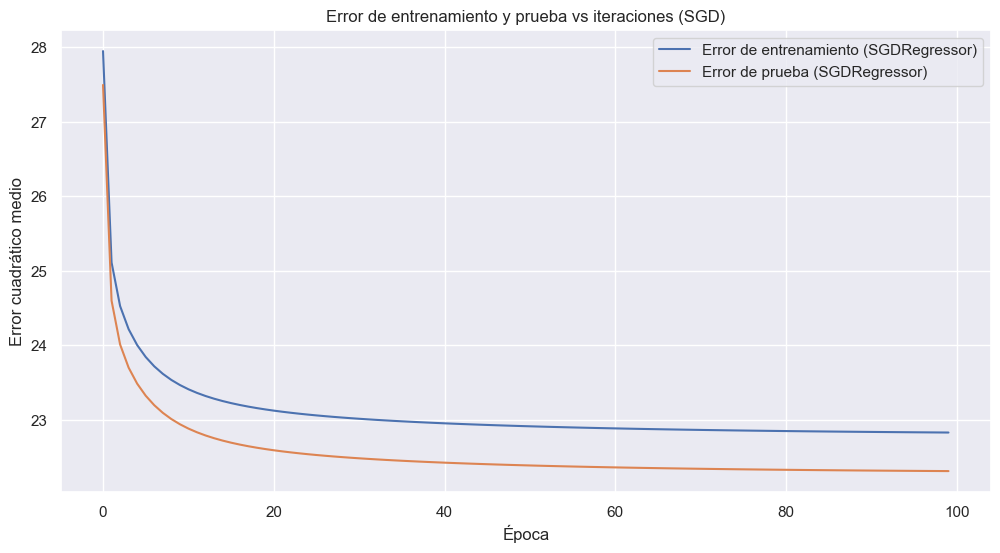

Época 10/50, Train MSE: 23.4658, Test MSE: 22.9399
Época 20/50, Train MSE: 23.1389, Test MSE: 22.6078
Época 30/50, Train MSE: 23.0216, Test MSE: 22.4913
Época 40/50, Train MSE: 22.9577, Test MSE: 22.4299
Época 50/50, Train MSE: 22.9163, Test MSE: 22.3911


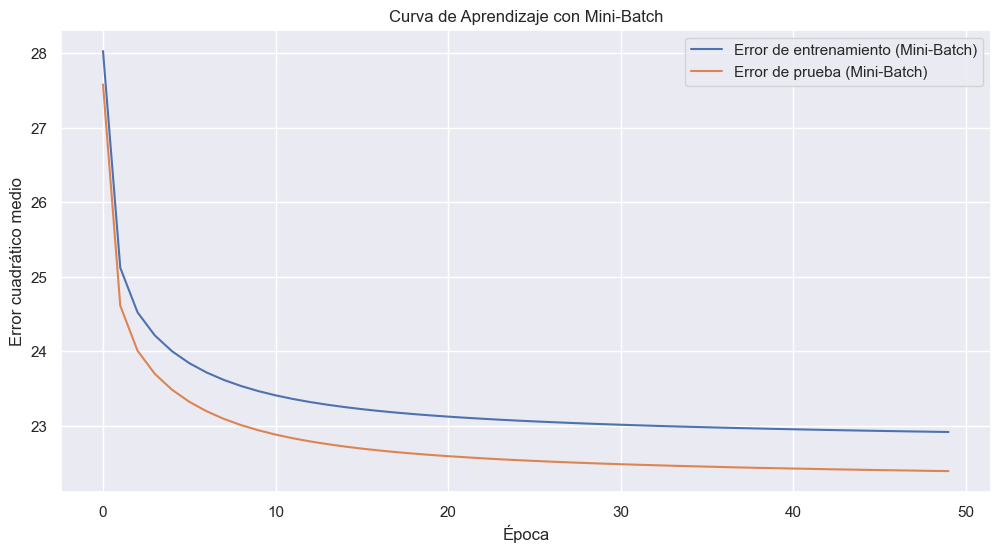

In [ ]:
from sklearn.linear_model import SGDRegressor


y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()



warm_start=True 
max_iter=1 
sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    penalty=None,  # Sin regularización, como en tu función
    learning_rate='invscaling',  # Tasa de aprendizaje constante
    eta0=0.0001,  # Tu valor de lr
    warm_start=True, # ¡Muy importante!
    random_state=42 # Opcional, para reproducibilidad
)


epochs = 100
train_errors = []
test_errors = []

for epoch in range(epochs):
    # Entrenar por una pasada completa sobre los datos (una época)
    sgd.partial_fit(X_train_scaled, y_train_flat)

    y_train_pred = sgd.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
      print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (SGDRegressor)')
plt.plot(range(epochs), test_errors, label='Error de prueba (SGDRegressor)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
plt.grid(True)
plt.show()


sgd = SGDRegressor(
    max_iter=1,  # Controlaremos las épocas manualmente
    tol=None,
    penalty=None,
    learning_rate='invscaling',
    eta0=0.0001,  # Un lr pequeño es bueno para mini-batch
    warm_start=True, # ¡CRÍTICO! No reinicia los pesos
    random_state=42
)


epochs = 50
batch_size = 100 # <<--- ¡AQUÍ ESTÁ TU PARÁMETRO!
n_samples = X_train_scaled.shape[0]

train_errors = []
test_errors = []


for epoch in range(epochs):


    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train_scaled[permutation]
    y_train_shuffled = y_train_flat[permutation]


    for j in range(0, n_samples, batch_size):
        # Tomar un lote
        x_batch = X_train_shuffled[j:j + batch_size]
        y_batch = y_train_shuffled[j:j + batch_size]

        sgd.partial_fit(x_batch, y_batch)

    # Después de pasar por todos los lotes (una época completa), medir el error
    y_train_pred = sgd.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (Mini-Batch)')
plt.plot(range(epochs), test_errors, label='Error de prueba (Mini-Batch)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Curva de Aprendizaje con Mini-Batch')
plt.grid(True)
plt.show()

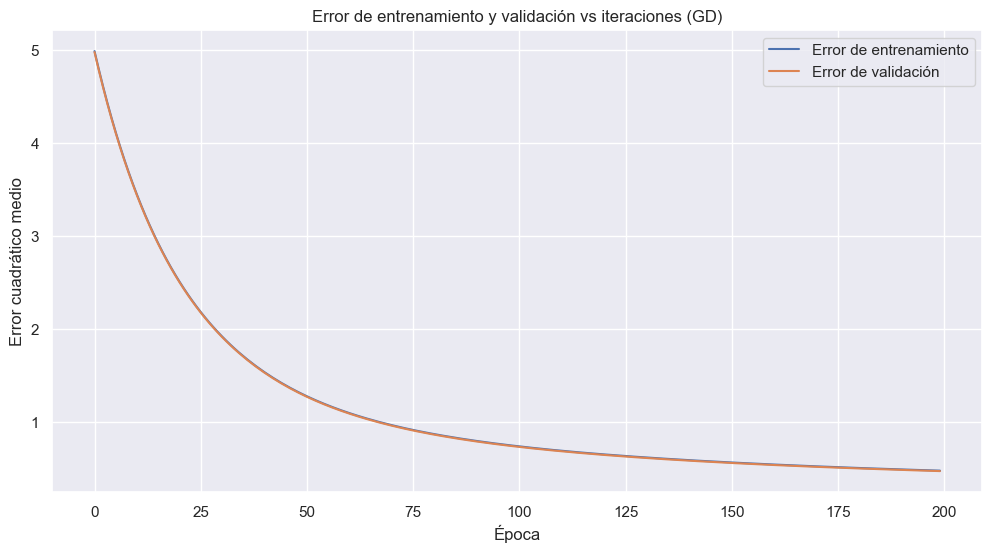

array([[-0.0799167 ],
       [ 0.04850301],
       [-0.00709662],
       [-0.21459752],
       [ 0.38141747],
       [ 0.62298351],
       [-0.39256711],
       [ 0.00348749],
       [-0.18859669],
       [ 1.09396084],
       [ 1.21768098],
       [-0.14327288],
       [ 2.17109264],
       [ 0.78505811],
       [ 0.04917937]])

In [ ]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=200)

In [ ]:
# stochastic_gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=100)

In [ ]:
# mini_batch_gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=100, batch_size=11)

# Regularización

## Ridge

In [ ]:
len(X_train_scaled), len(y_train_scaled)

(156804, 156804)

In [ ]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

model_ridge = make_pipeline(RidgeCV(alphas = np.logspace(-3, 6, 200),
                              fit_intercept   = True,
                              store_cv_results = True
                        )
         )

model_ridge.fit(X_train_scaled, y_train_scaled)
y_pred_ridge = model_ridge.predict(X_test_scaled)
r2_ridge = r2_score(y_test_scaled,y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_scaled,y_pred_ridge))
alpha_optimo = model_ridge.named_steps['ridgecv'].alpha_
print(f"Alpha optimo: {alpha_optimo}.")
print(f"R2: {r2_ridge}.")
print(f"RMSE: {rmse_ridge}.")
r2_ridge, rmse_ridge.item()

Alpha optimo: 16.070528182616385.
R2: 0.765600077478906.
RMSE: 0.488404820866789.


(0.765600077478906, 0.488404820866789)

Corregir error de diferente tamaño de muestras.

ValueError: x and y must be the same size

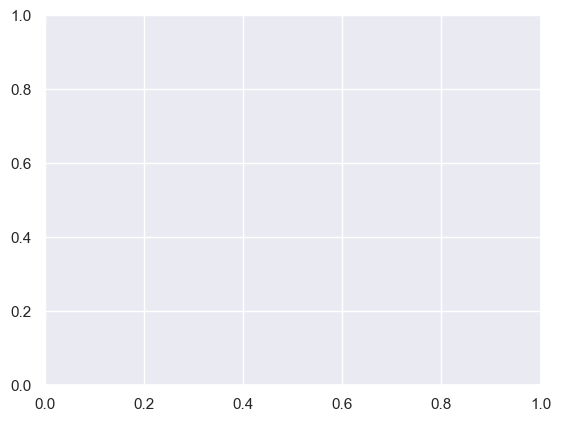

In [ ]:
# residuos_ridge = y_test_scaled - y_pred_ridge

# # Gráfico 1: Residuos vs Valores Predichos
# plt.scatter(y_pred_ridge, residuos_ridge, alpha=0.6)
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
# plt.xlabel('Valores Predichos')
# plt.ylabel('Residuos')
# plt.title('Residuos vs Valores Predichos')
# plt.grid(True, alpha=0.3)

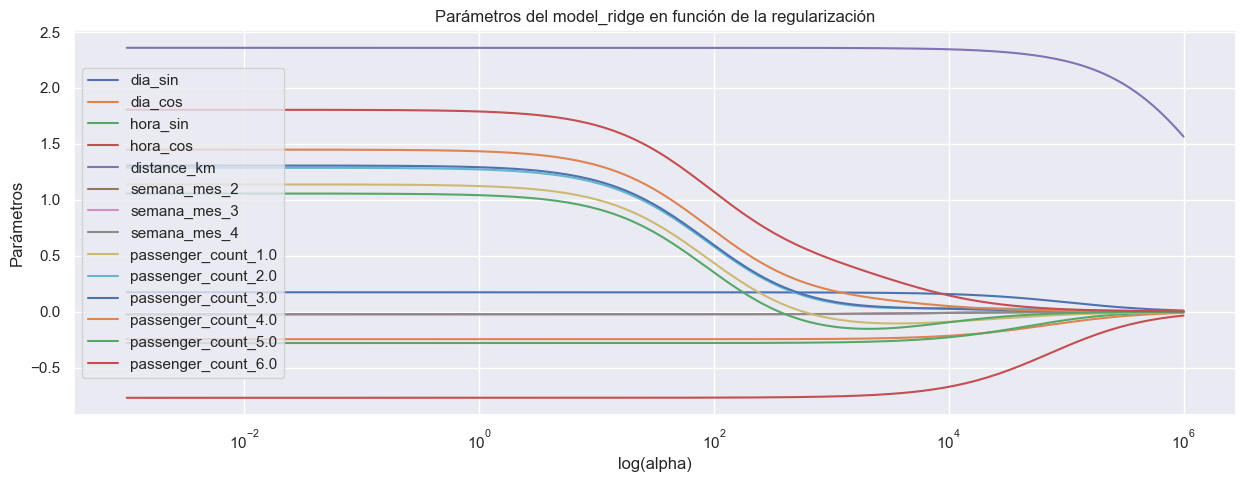

In [ ]:
# Evolución de los parámetros en función de alpha

alphas = model_ridge.steps[0][1].alphas
coefs = []

for alpha in alphas:
    model_ridge_aux = make_pipeline(Ridge(alpha=alpha))
    model_ridge_aux.fit(X_train, y_train)
    coefs.append(model_ridge_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del model_ridge en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

## Lasso

In [ ]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

model_lasso = make_pipeline(LassoCV(alphas = np.logspace(-3, 6, 200),
                              fit_intercept = True,
                              cv = 5
                        )
         )

model_lasso.fit(X_train, y_train)

y_pred_lasso= model_lasso.predict(X_test)
r2_lasso= r2_score(y_test,y_pred_lasso)
rmse_lasso= np.sqrt(mean_squared_error(y_test,y_pred_lasso))
alpha_optimo_lasso = model_lasso.named_steps['lassocv'].alpha_
print(f"Alpha optimo: {alpha_optimo_lasso}.")
r2_lasso, rmse_lasso

d:\Facultad\CUATRI 4\Aprendizaje Automático\TP\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha optimo: 0.005872786613189483.


(0.733774113044616, np.float64(5.12157093797449))

In [ ]:
residuos_ridge = y_test - y_pred_ridge

# Crear gráfico de residuos
plt.figure(figsize=(12, 8))

# Gráfico 1: Residuos vs Valores Predichos
plt.scatter(y_pred_ridge, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

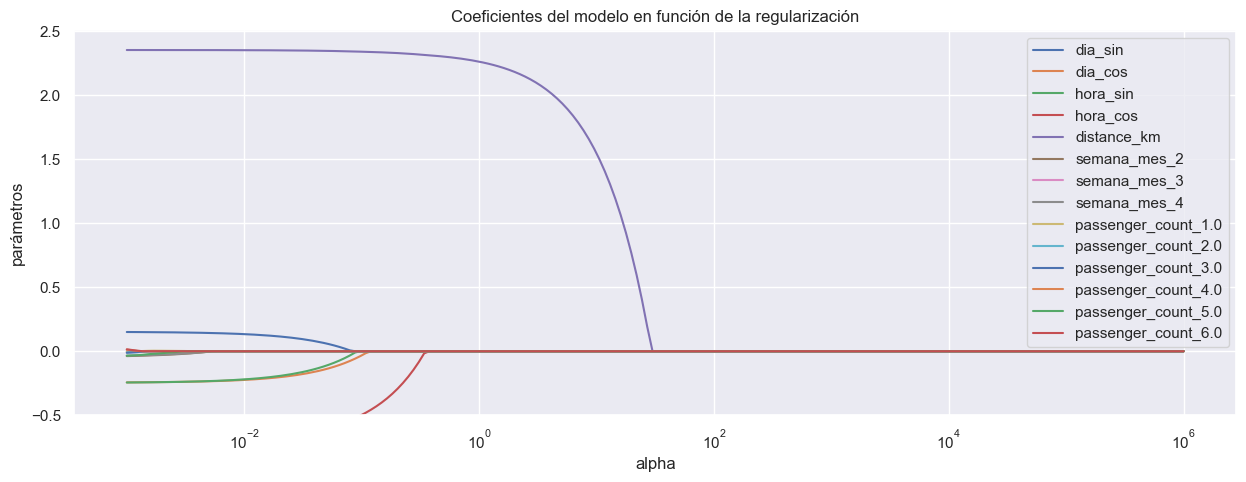

In [ ]:
# Evolución de los parámetros en función de alpha

mod = model_lasso.steps[0][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    model_lasso_aux = make_pipeline(Lasso(alpha=alpha))
    model_lasso_aux.fit(X_train, y_train)
    coefs.append(model_lasso_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

## ElasticNet

In [ ]:
model_elastic = make_pipeline(ElasticNetCV(
                              l1_ratio= [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas = np.logspace(-3, 4, 200),
                              cv = 5
                           )
         )

_ = model_elastic.fit(X_train, y_train)

mod = model_elastic.steps[0][1];

c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.088e+06, tolerance: 1.219e+03
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Thinkpad\Documents\aa1\AA1-TUIA-2025C2-Canciani-Morales-Mancini\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is d

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
rmse_elastic_net = df_resultados_cv['rmse_cv'].min()
df_resultados_cv

,l1_ratio,mod.alphas_,mse_cv,rmse_cv
1381,0.99,0.004297,25.621800,5.061798
1380,0.99,0.004660,25.621804,5.061798
1382,0.99,0.003963,25.621805,5.061799
1180,0.95,0.004660,25.621805,5.061799
1181,0.95,0.004297,25.621805,5.061799
...,...,...,...,...
653,0.70,136.671636,94.835724,9.738364
654,0.70,126.038293,94.835724,9.738364
660,0.70,77.525975,94.835724,9.738364
661,0.70,71.494290,94.835724,9.738364


Se puede observar que el mejor rmse se obtiene dejando un 0.1 de Lasso en el modelo de Elastic-Net. Esto ocurre porque, al haber coeficientes chicos de algunas variables, Ridge hace que valgan 0 demasiado rápido, haciendo que el modelo quede con menos informacion.  

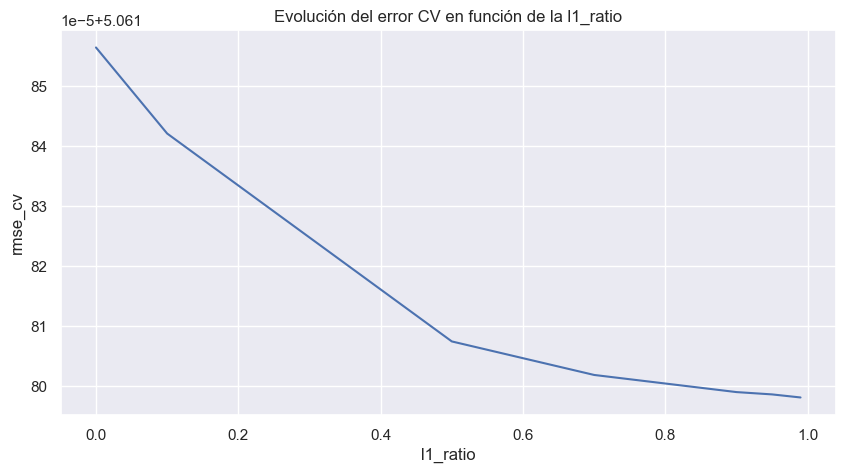

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.00429700470432084
Mejor valor de l1_ratio encontrado: 0.99


In [ ]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

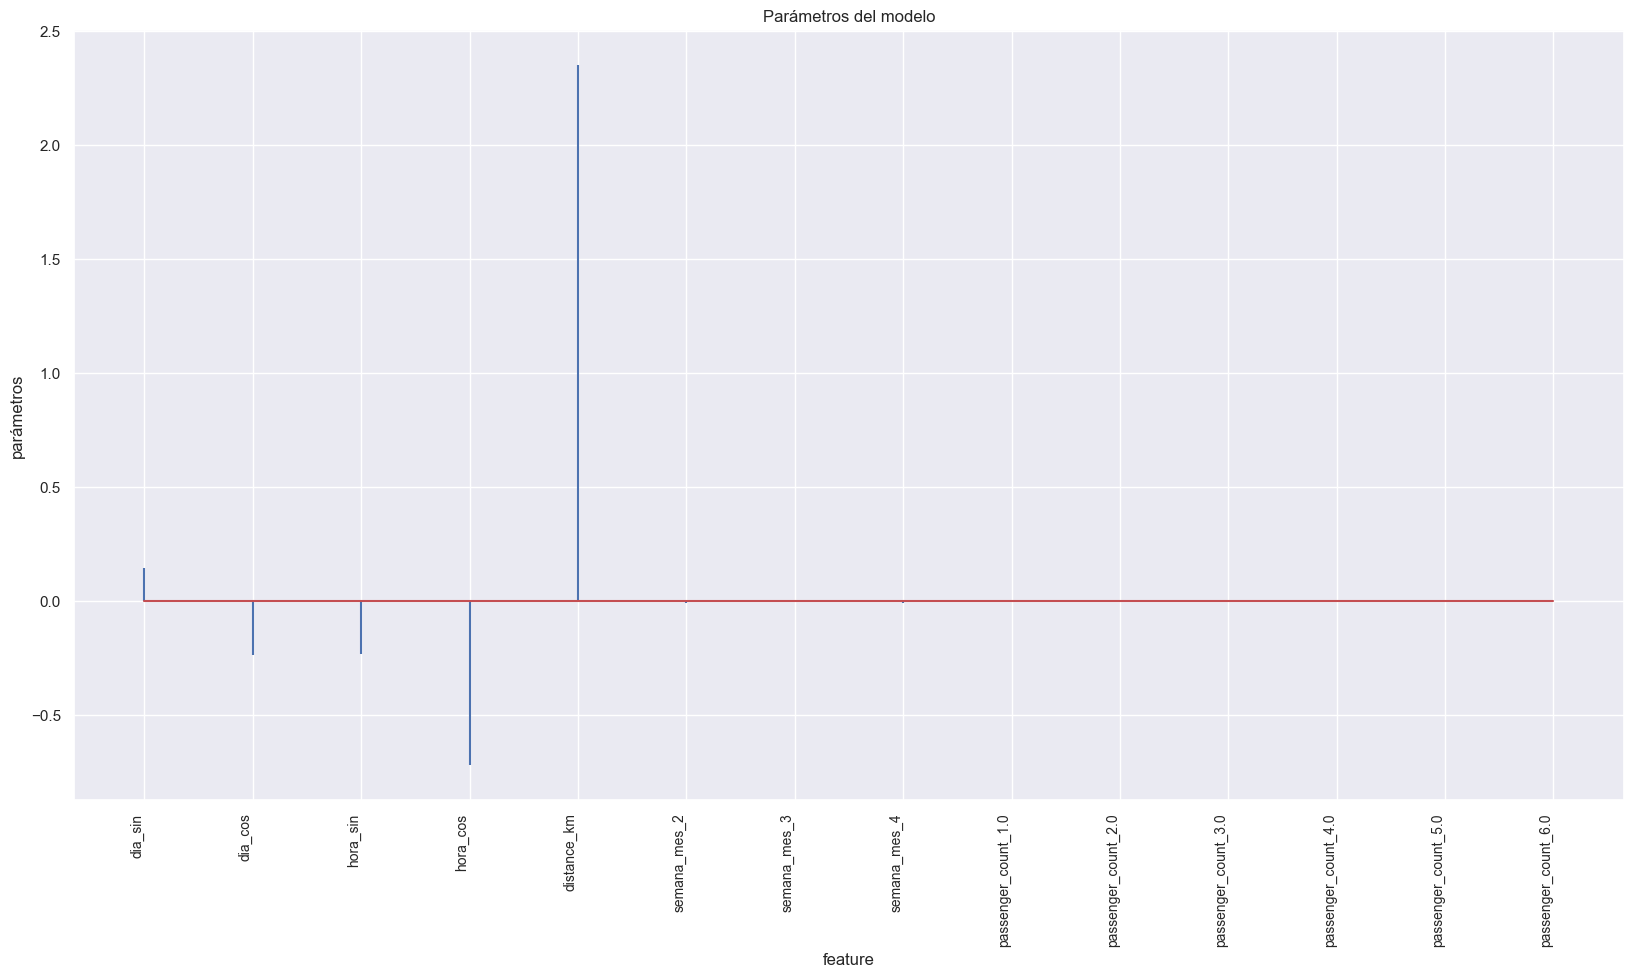

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

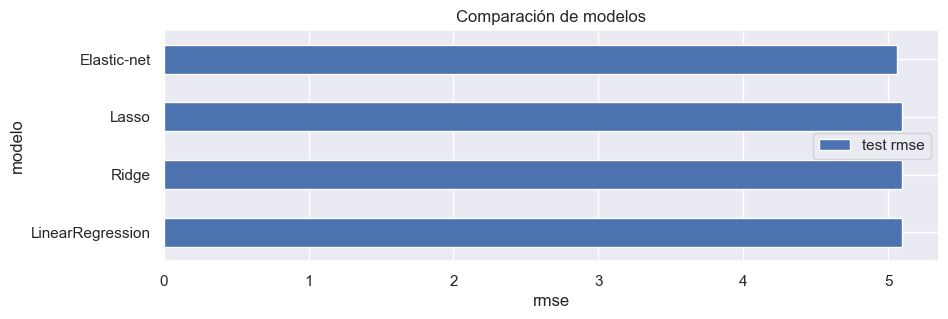

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse, rmse_ridge, rmse_lasso, rmse_elastic_net]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');